In [1]:
import fdapdepy as fdapde
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

In [2]:
# mesh
nodes = np.loadtxt("unit_square/points.txt", dtype=float)
triangles = np.loadtxt("unit_square/elements.txt", dtype=int)
triangles = triangles - 1 # sempre stessa storia
boundary = np.loadtxt("unit_square/boundary.txt", dtype=int)
nodes.shape

mesh = fdapde.domain(nodes, triangles, boundary)

type(mesh)

fdapdepy.domain.domain2d

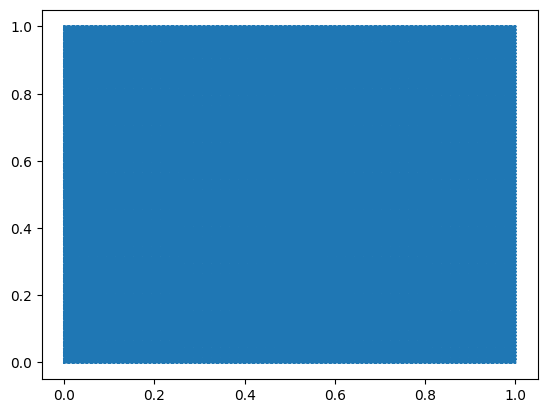

In [3]:
triangulation = Triangulation(mesh.nodes()[:,0], mesh.nodes()[:,1], mesh.elements())

fig, ax = plt.subplots()
ax.triplot(triangulation)

In [4]:
basis = fdapde.functional_basis(mesh, 1)
basis.size()
# non parametric comp
f = fdapde.function(basis)

In [5]:
Lf = -fdapde.laplacian(f)  
penalty = fdapde.pde(Lf) # forcing == 0.

In [6]:
u_ex = np.sin(np.pi*mesh.nodes()[:,0]) * np.sin(np.pi*mesh.nodes()[:,1])
u_ex = u_ex.reshape((u_ex.shape[0],1))
obs = u_ex + 0.05 * np.random.randn(nodes.shape[0],1)

In [7]:
model = fdapde.srpde(y=obs, data=None, penalty=penalty)

gcv_ = fdapde.gcv(lambda_= np.array([1e-5, 1e-4,1e-3, 1e-2, 1e-1, 1]).reshape(6,1))

In [8]:
gcv_

{'calibration': 'gcv',
 'lambda': array([[1.e-05],
        [1.e-04],
        [1.e-03],
        [1.e-02],
        [1.e-01],
        [1.e+00]]),
 'edf': 'stochastic',
 'n_mc_samples': 100,
 'seed': -1,
 'optimizer': 'grid',
 'max_iter': 20,
 'tolerance': 0.0001,
 'step': 0.01}

In [9]:
model.fit(calibration = gcv_)

dict_keys(['calibration'])


In [10]:
print(model.optimal_lambda())
print(model.f().shape)
print(u_ex.shape)
def rmse(x,y):
    return np.sqrt( np.mean( (x-y)*(x-y) ))
    
print("err_l_inf = ", np.max(np.abs(model.f() - u_ex.reshape(-1))))
print("err_l_2 = ", rmse( model.f(), u_ex.reshape(-1)))

[0.001]
(10201,)
(10201, 1)
err_l_inf =  0.05811634860633282
err_l_2 =  0.008783792746692526


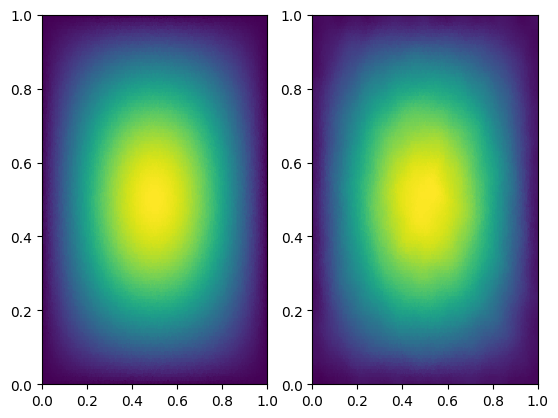

In [11]:
#plt.figure(figsize=(20,12))
#plt.style.use('_mpl-gallery-nogrid')

fig, ax = plt.subplots(1,2)
#ax.plot(nodes[:,0], nodes[:,1], markersize=, color='grey')
ax[0].tripcolor(nodes[:,0], nodes[:,1], u_ex.reshape(-1))
ax[0].set(xlim=(0, 1), ylim=(0, 1))

ax[1].tripcolor(nodes[:,0], nodes[:,1], model.f().reshape(-1))
ax[1].set(xlim=(0, 1), ylim=(0, 1))
plt.show()

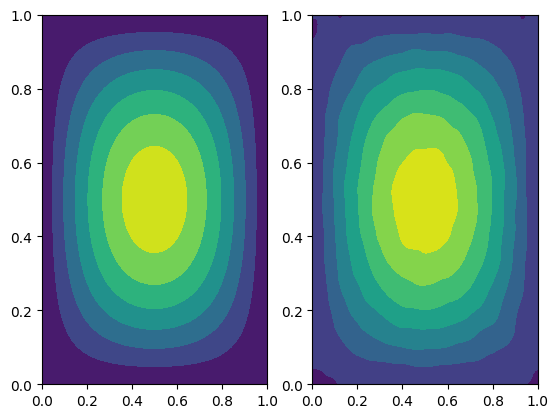

In [12]:
fig, ax = plt.subplots(1,2)
#ax.plot(nodes[:,0], nodes[:,1], markersize=, color='grey')
ax[0].tricontourf(nodes[:,0], nodes[:,1], u_ex.reshape(-1))
ax[0].set(xlim=(0, 1), ylim=(0, 1))

ax[1].tricontourf(nodes[:,0], nodes[:,1], model.f().reshape(-1))
ax[1].set(xlim=(0, 1), ylim=(0, 1))
plt.show()

dict_keys(['calibration'])
err_l_inf =  0.05811634860633282
err_l_2 =  0.008783792746692526


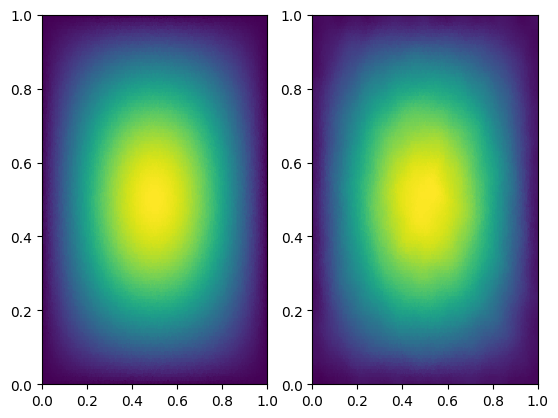

In [13]:
### --- formula locations at nodes
import pandas as pd
data = pd.DataFrame(obs, columns=["y"])

# domain
nodes = np.loadtxt("unit_square/points.txt", dtype=float)
triangles = np.loadtxt("unit_square/elements.txt", dtype=int)
triangles = triangles - 1 # sempre stessa storia
boundary = np.loadtxt("unit_square/boundary.txt", dtype=int)
mesh = fdapde.domain(nodes, triangles, boundary)
# FE basis
basis = fdapde.functional_basis(mesh, 1)
basis.size()
# penalty
f = fdapde.function(basis)
Lf = -fdapde.laplacian(f)  
penalty = fdapde.pde(Lf) # forcing == 0.
# srpde 
model = fdapde.srpde(formula="y ~ f", data=data, 
                     penalty=penalty)
gcv_ = fdapde.gcv(lambda_= np.array([1e-5, 1e-4,1e-3, 1e-2, 1e-1, 1]).reshape(6,1))
model.fit(calibration = gcv_)

# --- 
print("err_l_inf = ", np.max(np.abs(model.f() - u_ex.reshape(-1))))
print("err_l_2 = ", rmse( model.f(), u_ex.reshape(-1)))

fig, ax = plt.subplots(1,2)
ax[0].tripcolor(nodes[:,0], nodes[:,1], u_ex.reshape(-1))
ax[0].set(xlim=(0, 1), ylim=(0, 1))

ax[1].tripcolor(nodes[:,0], nodes[:,1], model.f().reshape(-1))
ax[1].set(xlim=(0, 1), ylim=(0, 1))
plt.show()

In [14]:
dict_ = fdapde.parse_formula("y~f", data)

print(len(dict_["covariates"]))
print(len(dict_["locations"]))

0
0


In [15]:
### --- formula + random locations 
import pandas as pd

nlocs = 500
p0 = np.random.uniform(0,1,nlocs)
p1 = np.random.uniform(0,1,nlocs)

u_ex = lambda p0, p1 : np.sin(np.pi*p0) * np.sin(np.pi*p1)
u_ = u_ex(p0,p1)
u_ =  u_.reshape((u_.shape[0],1))
obs = u_ + 0.05 * np.random.randn(nlocs,1)
print(obs.shape, p0.shape, p1.shape)
data = pd.DataFrame(np.matrix([obs.reshape(-1), p0, p1]).transpose(), columns=["y", "p0", "p1"])

(500, 1) (500,) (500,)


In [16]:
# domain
nodes = np.loadtxt("unit_square/points.txt", dtype=float)
triangles = np.loadtxt("unit_square/elements.txt", dtype=int)
triangles = triangles - 1 # sempre stessa storia
boundary = np.loadtxt("unit_square/boundary.txt", dtype=int)
mesh = fdapde.domain(nodes, triangles, boundary)
# FE basis
basis = fdapde.functional_basis(mesh, 1)
basis.size()
# penalty
f = fdapde.function(basis)
Lf = -fdapde.laplacian(f)  
penalty = fdapde.pde(Lf) # forcing == 0.
# srpde 
model = fdapde.srpde(formula="y ~ f(p0,p1)", data=data, 
                     penalty=penalty)
gcv_ = fdapde.gcv(lambda_= np.array([1e-5, 1e-4,1e-3, 1e-2, 1e-1, 1]).reshape(6,1))
model.fit(calibration = gcv_)

# --- 
print("err_l_inf = ", np.max(np.abs(model.f() - u_ex(nodes[:,0], nodes[:,1]))))
print("err_l_2 = ", rmse( model.f(), u_ex(nodes[:,0], nodes[:,1])))

fig, ax = plt.subplots(1,2)
ax[0].tripcolor(nodes[:,0], nodes[:,1], u_ex(nodes[:,0], nodes[:,1]))
ax[0].set(xlim=(0, 1), ylim=(0, 1))

ax[1].tripcolor(nodes[:,0], nodes[:,1], model.f().reshape(-1))
ax[1].set(xlim=(0, 1), ylim=(0, 1))
plt.show()

TypeError: unhashable type: 'list'